# Is podium


## Dependencies


The dependencies used are as follows


In [1]:
from xgboost import XGBClassifier, XGBRegressor, XGBRanker

import sys

sys.path.append("..")

from utils.custom_cvs import VariableTimeSeriesSplit
from utils.visualization import model_test
from utils.custom_scorers import balanced_accuracy_ranker, mean_absolute_ranker

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


The fifth objective attribute to be addressed will be if the driver is podium or not.


In [2]:
df = pd.read_csv("../assets/data/processed/other_models.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

scorers_ranker = [
    balanced_accuracy_ranker,
    mean_absolute_ranker,
]

labels = np.array(["not_podium", "podium"])
podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})

X = pd.read_csv("../assets/data/processed/other_models_X.csv")
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: int(x["driverRef"] in x["driverRefPodium"]), axis=1)

## XGBClassifier


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...):
CV with make_scorer(balanced_accuracy_score): 0.7764342373550369
CV with neg_mean_absolute_error: -0.09140391150612376
              precision    recall  f1-score   support

  not_podium       0.93      0.96      0.95      4545
      podium       0.71  

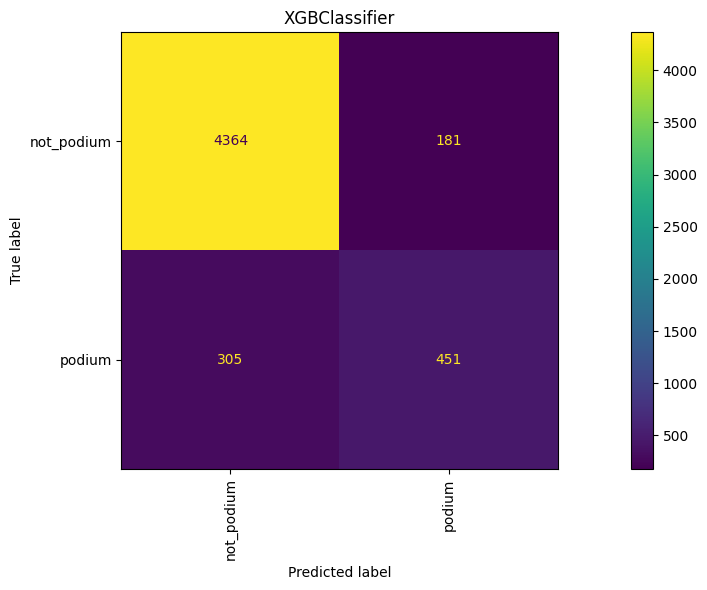

In [3]:
model = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    n_estimators=75,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=2,
    reg_lambda=2,
)
model_test((model,), X, y, tscv, labels=labels)

## XGBRegressor


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=75, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...):
CV with make_scorer(balanced_accuracy_score): 0.7777246394194327
CV with neg_mean_absolute_error: -0.1379947717428421
              precision    recall  f1-score   support

  not_podium       0.93      0.96      0.95      4545
      podium       0.72      0.6

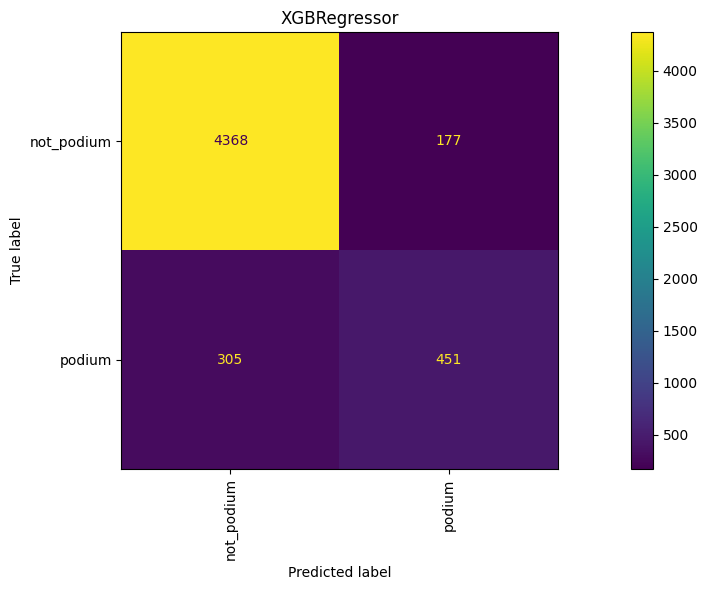

In [4]:
model = XGBRegressor(
    objective="reg:linear",
    learning_rate=0.1,
    n_estimators=75,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=2,
    reg_lambda=2,
)
model_test((model,), X, y, tscv, labels=labels)

## XGBRanker


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.75, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=3, max_leaves=None, min_child_weight=1,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=75, n_jobs=None, num_parallel_tree=None,
          objective='rank:pairwise', ...):
CV with balanced_accuracy_ranker: 0.8091303281845245
CV with mean_absolute_ranker: 0.09304303943174165
              precision    recall  f1-score   support

  not_podium       0.95      0.95      0.95      4545
      podium       0.67      0.67      0.67       756

    accuracy                    

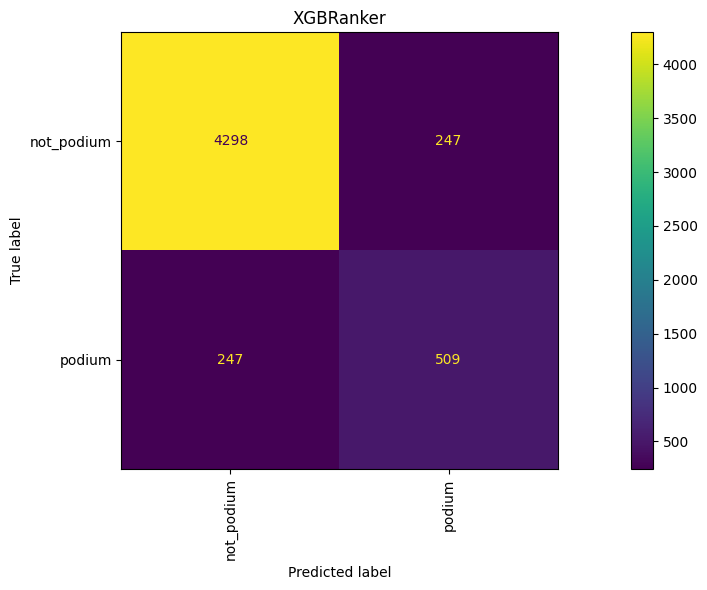

In [5]:
model = XGBRanker(
    objective="rank:pairwise",
    learning_rate=0.1,
    n_estimators=75,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=2,
    reg_lambda=2,
)
model_test(
    (model,),
    X,
    y,
    tscv,
    scorers=scorers_ranker,
    labels=labels,
    rank=True,
    multiclass=False,
)

## Results


They do not improve the results, but they match it even without optimizing.
